In [ ]:
# MFS
______________________________________________________________________________

Algorithm: Rau and Cornwell MFS

Implementation (C) L Bester, SKA-SA

Credit: B Hugo's gridding implementation, SKA-SA
    
Warning: Storing the DFT kernels makes this a memory hungry beast. 
With 64 pixels and 16 channels a run requires about 6GB 
With 128 pixels and 16 channels a run requires about 13GB
______________________________________________________________________________

In [1]:
import math as mp
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from pyrap.tables import table as tbl
import scipy.signal
import time
from IPython.display import clear_output
from IPython.html.widgets import FloatProgress
from IPython.display import display
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy import optimize as opt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

/home/landman/virtualenvmts/fundamentals/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/landman/virtualenvmts/fundamentals/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
class AA_filter:
    """
    Anti-Aliasing filter
    
    Keyword arguments for __init__:
    filter_half_support --- Half support (N) of the filter; the filter has a full support of N*2 + 1 taps
    filter_oversampling_factor --- Number of spaces in-between grid-steps (improves gridding/degridding accuracy)
    filter_type --- box (nearest-neighbour), sinc or gaussian_sinc
    """
    half_sup = 0
    oversample = 0
    full_sup_wo_padding = 0
    full_sup = 0
    no_taps = 0
    filter_taps = None
    def __init__(self, filter_half_support, filter_oversampling_factor, filter_type):
        self.half_sup = filter_half_support
        self.oversample = filter_oversampling_factor
        self.full_sup_wo_padding = (filter_half_support * 2 + 1)
        self.full_sup = self.full_sup_wo_padding + 2 #+ padding
        self.no_taps = self.full_sup + (self.full_sup - 1) * (filter_oversampling_factor - 1)
        taps = np.arange(self.no_taps)/float(filter_oversampling_factor) - self.full_sup / 2
        if filter_type == "box":
            self.filter_taps = np.where((taps >= -0.5) & (taps <= 0.5),
                                        np.ones([len(taps)]),np.zeros([len(taps)]))
        elif filter_type == "sinc":
            self.filter_taps = np.sinc(taps)
        elif filter_type == "gaussian_sinc":
            alpha_1=1.55
            alpha_2=2.52
            self.filter_taps = np.sin(np.pi/alpha_1*(taps+0.00000000001))/(np.pi*(taps+0.00000000001))*np.exp(-(taps/alpha_2)**2)
        else:
            raise ValueError("Expected one of 'box','sinc' or 'gausian_sinc'")

In [25]:
class grid_it(object):
    
    def __init__(self,uvw,ref_lda,Nx,Ny,convolution_filter,degrid_mode="normal"):
        self.uvw = uvw
        self.ref_lda = ref_lda
        self.Nx = Nx
        self.Ny = Ny
        self.nchan = ref_lda.size
        self.nvis = uvw.shape[0]
        self.convolution_filter = convolution_filter
    
    def Init_DFT(self,ra0,dec0,uvw,delta_pix):
        #Set coords (should set delta_pix in x and y directions if not square image)
        ra = ra0 + np.linspace(ra0 - self.Nx*delta_pix/2.0,ra0 + self.Nx*delta_pix/2.0,npix)
        delta_ra = ra - ra0
        dec = dec0 + np.linspace(dec0 - self.Ny*delta_pix/2.0,dec0 + self.Ny*delta_pix/2.0,npix)
        l = (np.cos(dec)*np.sin(delta_ra))
        m = (-np.sin(dec)*np.cos(dec0) - np.cos(dec)*np.sin(dec0)*cos(delta_ra))
        #Get l,m,n triple
        self.ncoord = np.zeros(self.Nx*self.Ny)
        lmn = np.zeros([self.Nx*self.Ny,3])
        for i in xrange(self.Nx):
            for j in xrange(self.Ny):
                self.ncoord[i*self.Ny + j] = np.sqrt(1.0 - l[i]**2 - m[j]**2)
                lmn[i*self.Ny + j,0] = l[i]
                lmn[i*self.Ny + j,1] = m[j]
                lmn[i*self.Ny + j,2] = self.ncoord[i*self.Ny+j] - 1.0        
        #Precompute DFT kernel
        tmp = -2.0j*np.pi*dot(uvw,lmn.T)
        self.K = np.zeros([self.nchan,self.nvis,self.Nx*self.Ny],dtype=complex)
        for k in range(self.nchan):
                self.K[k,:,:] = np.exp(tmp/self.ref_lda[k])    
        
    def do_DFT_Vpred(self,IM):
        """
        DFT to predict Vis from IM
        """
        tmp = np.zeros([self.nchan,self.nvis],dtype=complex)
        for i in range(self.K.shape[0]):
            tmp[i,:] = np.dot(self.K[i],np.flipud(IM[i]).T.flatten()/self.ncoord)
        return tmp.T #/2
            
    def give_IR(self,vis):
        filter_index = np.arange(-self.convolution_filter.half_sup,self.convolution_filter.half_sup+1)
        measurement_regular = np.zeros([self.nchan,self.Ny,self.Nx],dtype=np.complex) #one grid for the resampled visibilities

        for r in range(0,self.nvis):
            for c in range(self.nchan):
                scaled_uv = self.uvw[r,:] / self.ref_lda[c] 
                disc_u = int(scaled_uv[0])
                disc_v = int(scaled_uv[1])
                frac_u_offset = int((self.convolution_filter.half_sup + 1 + (-scaled_uv[0] + disc_u)) * self.convolution_filter.oversample)
                frac_v_offset = int((self.convolution_filter.half_sup + 1 + (-scaled_uv[1] + disc_v)) * self.convolution_filter.oversample)
                if (disc_v + self.Ny // 2 + self.convolution_filter.half_sup >= self.Ny or 
                    disc_u + self.Nx // 2 + self.convolution_filter.half_sup >= self.Nx or
                    disc_v + self.Ny // 2 - self.convolution_filter.half_sup < 0 or 
                    disc_u + self.Nx // 2 - self.convolution_filter.half_sup < 0): 
                    continue
                for conv_v in filter_index:
                    v_tap = self.convolution_filter.filter_taps[conv_v * self.convolution_filter.oversample + frac_v_offset]  
                    grid_pos_v = disc_v + conv_v + self.Ny // 2
                    for conv_u in filter_index:
                        u_tap = self.convolution_filter.filter_taps[conv_u * self.convolution_filter.oversample + frac_u_offset]
                        conv_weight = v_tap * u_tap
                        grid_pos_u = disc_u + conv_u + self.Nx // 2
                        measurement_regular[c,grid_pos_v,grid_pos_u] += vis[r,c] * conv_weight              
        dirty = np.zeros(measurement_regular.shape,dtype=measurement_regular.dtype)
        for c in range(self.nchan):
            dirty[c,:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(measurement_regular[c,:,:])))
        return dirty/4.0
    
    def give_Vpred(self,Image):
        """
        Predict with convolutional degridder (not working at the moment)
        """
        filter_index = np.arange(-self.convolution_filter.half_sup,self.convolution_filter.half_sup+1)
        
        vis_grid = np.zeros([self.nchan,self.Nx,self.Ny])
        for i in range(self.nchan):
            vis_grid[i] = fft.fftshift(fft.fft2(fft.ifftshift(Image[i])))
        vis = np.zeros([self.uvw.shape[0],self.ref_lda.size],dtype=complex)
        for r in range(0,self.nvis):
            for c in range(self.nchan):
                scaled_uv = self.uvw[r,:] / self.ref_lda[c] 
                disc_u = int(scaled_uv[0])
                disc_v = int(scaled_uv[1])
                frac_u_offset = int((self.convolution_filter.half_sup + 1 + (-scaled_uv[0] + disc_u)) * self.convolution_filter.oversample)
                frac_v_offset = int((self.convolution_filter.half_sup + 1 + (-scaled_uv[1] + disc_v)) * self.convolution_filter.oversample)
                if (disc_v + self.Ny // 2 + self.convolution_filter.half_sup >= self.Ny or 
                    disc_u + self.Nx // 2 + self.convolution_filter.half_sup >= self.Nx or
                    disc_v + self.Ny // 2 - self.convolution_filter.half_sup < 0 or 
                    disc_u + self.Nx // 2 - self.convolution_filter.half_sup < 0): 
                    continue
                for conv_v in filter_index:
                    v_tap = self.convolution_filter.filter_taps[conv_v * self.convolution_filter.oversample + frac_v_offset]  
                    grid_pos_v = disc_v + conv_v + self.Ny // 2
                    for conv_u in filter_index:
                        u_tap = self.convolution_filter.filter_taps[conv_u * self.convolution_filter.oversample + frac_u_offset]
                        conv_weight = v_tap * u_tap
                        grid_pos_u = disc_u + conv_u + self.Nx // 2
                        vis[r,c] += vis_grid[c,grid_pos_v,grid_pos_u] * conv_weight              
        return vis

In [4]:
def grid_ifft(vis,uvw,ref_lda,Nx,Ny,convolution_filter):
    """
    Convolutional gridder (continnuum)
    
    Keyword arguments:
    vis --- Visibilities as sampled by the interferometer
    uvw --- interferometer's scaled uvw coordinates. (Prerequisite: these uv points are already scaled by the simularity
            theorem, such that -N_x*Cell_l*0.5 <= theta_l <= N_x*Cell_l*0.5 and
            -N_y*Cell_m*0.5 <= theta_m <= N_y*Cell_m*0.5
    ref_lda --- array of reference lambdas (size of vis channels)
    Nx,Ny --- size of image in pixels
    convolution_filter --- pre-instantiated AA_filter anti-aliasing filter object
    """
    assert vis.shape[1] == ref_lda.shape[0], (vis.shape[1], ref_lda.shape[0])
    filter_index = np.arange(-convolution_filter.half_sup,convolution_filter.half_sup+1)
    measurement_regular = np.zeros([vis.shape[1],vis.shape[2],Ny,Nx],dtype=np.complex) #one grid for the resampled visibilities
    #for deconvolution the PSF should be 2x size of the image (see Hogbom CLEAN for details):
    sampling_regular = np.zeros([vis.shape[1],2*Ny,2*Nx],dtype=np.complex) #one grid for the resampled sampling function
    
    pbar = FloatProgress(min=0, max=100)
    display(pbar)
    for r in range(0,uvw.shape[0]):
        pbar.value = r / float(uvw.shape[0]) * 100
        for c in range(vis.shape[1]):
            scaled_uv = uvw[r,:] / ref_lda[c] 
            disc_u = int(scaled_uv[0])
            disc_v = int(scaled_uv[1])
            frac_u_offset = int((convolution_filter.half_sup + 1 + (-scaled_uv[0] + disc_u)) * convolution_filter.oversample)
            frac_v_offset = int((convolution_filter.half_sup + 1 + (-scaled_uv[1] + disc_v)) * convolution_filter.oversample)
            disc_u_psf = int(scaled_uv[0]*2)
            disc_v_psf = int(scaled_uv[1]*2)
            frac_u_offset_psf = int((convolution_filter.half_sup + 1 + (-scaled_uv[0]*2 + disc_u_psf)) * convolution_filter.oversample)
            frac_v_offset_psf = int((convolution_filter.half_sup + 1 + (-scaled_uv[1]*2 + disc_v_psf)) * convolution_filter.oversample)
            if (disc_v + Ny // 2 + convolution_filter.half_sup >= Ny or 
                disc_u + Nx // 2 + convolution_filter.half_sup >= Nx or
                disc_v + Ny // 2 - convolution_filter.half_sup < 0 or 
                disc_u + Nx // 2 - convolution_filter.half_sup < 0): 
                continue
            for conv_v in filter_index:
                v_tap = convolution_filter.filter_taps[conv_v * convolution_filter.oversample + frac_v_offset]  
                v_tap_psf = convolution_filter.filter_taps[conv_v * convolution_filter.oversample + frac_v_offset_psf]  
                grid_pos_v = disc_v + conv_v + Ny // 2
                grid_pos_v_psf = disc_v_psf + conv_v + Ny
                for conv_u in filter_index:
                    u_tap = convolution_filter.filter_taps[conv_u * convolution_filter.oversample + frac_u_offset]
                    u_tap_psf = convolution_filter.filter_taps[conv_u * convolution_filter.oversample + frac_u_offset_psf]
                    conv_weight = v_tap * u_tap
                    conv_weight_psf = v_tap_psf * u_tap_psf
                    grid_pos_u = disc_u + conv_u + Ny // 2
                    grid_pos_u_psf = disc_u_psf + conv_u + Nx
                    for p in range(vis.shape[2]):
                        measurement_regular[c,p,grid_pos_v,grid_pos_u] += vis[r,c,p] * conv_weight
                    sampling_regular[c,grid_pos_v_psf,grid_pos_u_psf] += (1+0.0j) * conv_weight_psf
                    
    dirty = np.zeros(measurement_regular.shape,dtype=measurement_regular.dtype)
    psf = np.zeros(sampling_regular.shape,dtype=sampling_regular.dtype)
    
    for c in range(vis.shape[1]):
        for p in range(vis.shape[2]):
            dirty[c,p,:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(measurement_regular[c,p,:,:])))
        psf[c,:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sampling_regular[c,:,:])))
    return dirty/4.0,psf

# Imaging

## Iterative $\chi^2$ minimisation

The imaging problem can be formulated as an iterative $\chi^2$ minimisation of a system of linear equations of the form
$$ Ax = b + \epsilon,$$
where $\epsilon$ is iid Gaussian noise. This allows us to form the $\chi^2$ distribution as
$$ \chi^2 = (Ax - b)^\dagger W (Ax - b), $$
where $W$ is a diagonal matrix of weights and the superscript $\dagger$ denotes the conjugate transpose operator. The assumption that $\epsilon$ is Gaussian noise basically ensures that the quantity we are optimising only has a single stationary point. If $\epsilon$ was not Gaussian but rather some multi-modal distribution, then the quantity $\epsilon^\dagger \epsilon$ could also have a multi-modal distribution. 

The goal is to find the set of parameters $x$ which minimises $\chi^2$. The gradient of $\chi^2$ is given by
$$ \partial_x \chi^2 = J(x) = A^\dagger W (b - Ax), $$
where we have used the standard linear algebra notation $J(x)$ to denote the Jacobian (or, since $\chi^2$ is scalar, also the gradient). One more derivative gives the Hessian $H(x)$ as 
$$ \partial^2_x \chi^2 = H = A^\dagger W A. $$
Furthermore, setting the gradient to zero produces the normal equations
$$ A^\dagger W A x = A^\dagger W b, $$
If the Hessian matrix $H = A^H W A$ is non-singular we could solve for $x$ directly from the normal equations
$$ x = \left( A^\dagger W A  \right)^{-1} A^\dagger W b. $$
Unfortunately, because of incomplete $uv$-coverage, in interferometry the Hessian matrix will almost always be singular. In this case an approximate iterative solution can still be found (from an initial guess, $x_0$ say) using a numerical root finding algorithm such as Newton's method i.e.
$$ x_{i+1} = x_i + \tilde{H}^{-1}(x_i) J(x_i), $$
where $\tilde{H}(\cdot)$ is some invertible approximation of the Hessian matrix (eg. a diagonal approximation). When the Hessian does not have full column rank the solution to the normal equations is not unique. The solution is ambiguous w.r.t. the addition of any vector $\tilde{x}$ in the null space of the Hessian i.e. $H\tilde{x} = 0$. The reason for this is that, according to the normal equations, we have
$$ H(x + \tilde{x}) = Hx = A^\dagger W b, $$
regardless of the choice of $\tilde{x}$. 

## Imaging as an iterative $\chi^2$ minimisation problem

The imaging problem can be formulated according to the above framework by identifying $A = SF$ i.e.
$$ S F I = V_{obs} + \epsilon,$$
where $S$ is the sampling operator, $F$ the Fourier transform and $I$ is the image we want to deconvolve. Direct substitution yields the $\chi^2$ distribution as
$$ \chi^2 = (S F I - V_{obs})^\dagger W (S F I - V_{obs}), $$
where $W$ are the imaging weights. The goal is to find the image $I$ which minimises $\chi^2$. 
In this case the gradient is given by
$$ \partial_x \chi^2 = J(I) = F^\dagger S^\dagger W (S F I - V_{obs}), $$
and the Hessian is 
$$ \partial^2_x \chi^2 = H = F^\dagger S^\dagger W S F. $$
Since $S$ will not, in general, have full column rank we have to find the solution iteratively using an update rule such as
$$ I_{i+1} = I_i + g \tilde{H}^{-1} J(I_i), $$
where $g$ controls the step size. The normal equations are given by
$$ HI = I_D, \quad \mbox{where} \quad H = F^\dagger S^\dagger W SF, \quad \mbox{and} \quad I^D = F^\dagger S^\dagger W V_{obs}.  $$
Here $I_D$ denotes the dirty image which can be thought of as the image $I$ convolved with the point spread function, denoted $I^{PSF}$, of the instrument i.e. $I^D = I^{PSF} * I$. For this reason the solution to the normal equations can be thought of as a deconvolution. 

In imaging the iterative solution is usually implemented using major and minor cycles. To see how this works first note that, for a given model image $I^{M}$, the Jacobian is just the residual image i.e. 
$$ J(I^{M}) = F^\dagger S^\dagger W (S F I^M - V_{obs}) = I^{R}. $$
Thus one iteration of the optimisation method would be given by 
$$ I^M_{i+1} = I^M_{i} + g \tilde{H}^{-1} I^R_{i}, $$
where $\tilde{H}$ is constructed by invoking a number of a priori assumptions. Recall that an ideal interferometer (i.e. one with complete $uv$-coverage) will have a delta function as its PSF. This suggests that we can, in principle, eliminate the corrupting effects of the instrument by assuming that the PSF is a delta function. This is equivalent to a diagonal approximation of the Hessian matrix. If we also assume that the PSF is spatially invariant all the elements on the diagonal will be the same and the Hessian reduces to a single number viz. the value of $I^{PSF}$ at the center. With these two assumptions we can construct 
$$ \tilde{H} = \mbox{mid}(I^{PSF}). $$
This allows us to construct what is known as the principal solution $\hat{I}^D$ as
$$ \hat{I}^D = \tilde{H}^{-1} I^D, \qquad \hat{I}^{PSF} = \tilde{H}^{-1} I^{PSF}. $$
Note that we are using a hat to denote normalisation by the peak of the PSF. Thus the principal solution is basically just the dirty image normalised so that it has the same units as the image of the sky. Note that the inverse of the Hessian matrix will only exist (i.e. be finite) at locations corresponding to non-zero pixels in the image. Thus, to apply the update step, we start by searching for the peak in $I^D$ and only perform the Hessian inversion locally. We can then compute the new residual image (i.e. evaluate the Jacobian) and repeat until some prespecified convergence criterion has been reached. However, since evaluating the Jacobian is an expensive operation, the algorithm is usually implemented slightly differently. This is where the distinction between minor and major cycles comes in. Major cycles evaluate the Jacobian while minor cycles implement more efficient (but less accurate) updates to the model image. 

It is impractical to build the model image one pixel at a time. To speed things up a bit we might want to add multiple pixels (the brightest ones) to the model image during the minor cycle. This requires performing the subtraction (equivalently computing the Jacobian or updating the residual image $I^R$) in the image domain and can be implemented approximately by subtracting out the PSF centered at the location of the current brightest pixel from the entire image. However, since we are evaluating the PSF on a finite grid, this inevitably introduces discretisation errors which must be corrected for in the major cycle. Below we load some simulated data and illustrate the Cotton-Schwabb CLEAN algorithm (actually it is a slight modification which searches for the peak in the average image over channels which has the effect of increasing the SNR in the presence of noise). 

In [33]:
#Load in MS
ms = tbl("DATA/mfs_sky.MS_p0/")

#Get freq info
msfreq = tbl("DATA/mfs_sky.MS_p0::SPECTRAL_WINDOW")

#Get pointing center (to compute DFT kernel)
msfield = tbl("DATA/mfs_sky.MS_p0::FIELD")
ra0, dec0 = msfield.getcol("PHASE_DIR").squeeze() #in radians

#Set AA filter
aa = AA_filter(3,63,"sinc")

#Some constants and conversion factors
c = 2.99792458e8 #speed of light
npix = 65 #note using odd number otherwise centre of PSF is not well defined
ARCSEC2RAD = 4.8481e-6
delta_pix = 2 * ARCSEC2RAD * 2 * 2 * 2 * 2 #add or remove a power of two depending on image size
uv_scale = npix * delta_pix

#Select subset of data
chanstep = 4
nrows = 2000 #-1 to select all
uvw = ms.getcol("UVW")[0:nrows,:] 
vis = ms.getcol("DATA")[0:nrows,0::chanstep,:]
scaled_uvw = uvw * uv_scale

#Get frequencies
Freqs = msfreq.getcol("CHAN_FREQ").squeeze()[0::chanstep]
nchan = Freqs.size
ref_freq = Freqs[nchan/2]

#Close tables
ms.close()
msfreq.close()
msfield.close()

#Get wavelengths
ref_lambda = c / Freqs

#Compute dirty and psf using gridder
print "Getting PSF and ID"
dirty,psf = grid_ifft(vis,scaled_uvw,ref_lambda,npix,npix,aa)

#Get ID and PSF
ID = np.real((dirty[:,0,:,:]+dirty[:,3,:,:])*0.5)
PSF = np.abs(psf)

#Get V corresponding to stokes I 
Vobs = (vis[:,:,0] + vis[:,:,3])*0.5

#Instantiate the gridder
print "Initialising grid machine"
gridder = grid_it(scaled_uvw,ref_lambda,npix,npix,aa)
gridder.Init_DFT(ra0,dec0,uvw,delta_pix)

print "Done"

Successful readonly open of default-locked table DATA/mfs_sky.MS_p0/: 25 columns, 237276 rows
Successful readonly open of default-locked table DATA/mfs_sky.MS_p0::SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table DATA/mfs_sky.MS_p0::FIELD: 9 columns, 1 rows
Getting PSF and ID
Initialising grid machine
Done


## Cotton-Schwabb 

In [34]:
def CLEAN_CS(Vobs,ID,PSF,gridder,
             gamma = 0.05,threshold = "Default", nminoriter = 50,
             nmajoriter = 50):
    """
    This is a basic CLEAN implemented using major and minor cycles. 
    Input:  Vobs = precalibrated visibilities
            ID = the un-nprmalised dirty image
            PSF = the unnormalised PSF
            gridder = instance of a gridder and degridder
    """
    #Initialise model image
    n = Vobs.shape[0]
    nchan = Vobs.shape[1]
    npix = ID.shape[-1]
    IM = np.zeros([nchan,npix,npix])
    
    #Get maximum of PSF in all the channels
    PSF_max = np.zeros(nchan)
    for nu in xrange(nchan):
        PSF_max[nu] = np.max(PSF[nu])
        
    #Get the mean image
    Imean = np.mean(ID,axis=0)
    
    #Find first maximum
    p,q = (argwhere(Imean == Imean.max())[0]).squeeze()
    Istarm = Imean[p,q]
    
    #Get principle solution
    Istar = ID[:,p,q]/PSF_max
    
    #print "First peak = ", Istar
    
    #Set threshold
    if threshold=="Default":
        threshold = 0.25*np.abs(Istarm)
        print "Threshold set at ", threshold
    else:
        print "Assuming user set threshold"
        
    #Start deconvolution
    i = 0
    IR = ID.copy()
    while (i < nmajoriter) and (Istarm > 0.25*threshold):
        #Enter minor cycle
        j = 0
        while (j < nminoriter) and (Istarm > threshold):
            #Update model image
            IM[:,p,q] += gamma*Istar
            
            #Do image plane subtraction
            IR -= gamma*Istar[:,np.newaxis,np.newaxis]*PSF[:,npix - p:2*npix - p,npix - q:2*npix - q] 
            
            #Get mean image
            Imean = np.mean(IR,axis=0)
            
            #Get new indices where IR is max
            p,q = (argwhere(Imean == Imean.max())[0]).squeeze()
            Istarm = Imean[p,q]
            
            #Get principal solution
            Istar = IR[:,p,q]/PSF_max
            
            #Increment minor cycle counter
            j += 1 
        #Increment major cycle counter
        i += 1
        
        #Update model image
        IM[:,p,q] += 10*gamma*Istar
        
        #Get residual image
        IR = get_Jacobian(Vobs,IM,gridder)
        
        #Get mean image
        Imean = np.mean(IR,axis=0)        
        
        #Find new max
        p,q = (argwhere(Imean == Imean.max())[0]).squeeze()
        Istarm = Imean[p,q]
        
        #Get principle solution
        Istar = IR[:,p,q]/PSF_max
        
        if i%5==0:
            print "i = ", i, "j = ", j, "Istarm = ", Istarm
            
    #Warn if number of iterations exceeded
    if i >= nmajoriter:
        print "Max iterations exceeded. Istar = ",Istarm
    print "Done"
    return IM, IR
    
    
def get_Jacobian(Vobs,IM,gridder):
    #Degrid
    Vpred = gridder.do_DFT_Vpred(IM)
    
    #Get residual vis
    Vres = Vobs - Vpred
    
    #Grid residuals to find IR
    IR = np.real(gridder.give_IR(Vres))

    return IR

In [35]:
print "Doing CS CLEAN"
IM, IR = CLEAN_CS(Vobs.copy(),ID.copy(),PSF.copy(),gridder)

Doing CS CLEAN
Threshold set at  0.0283361610226
Done


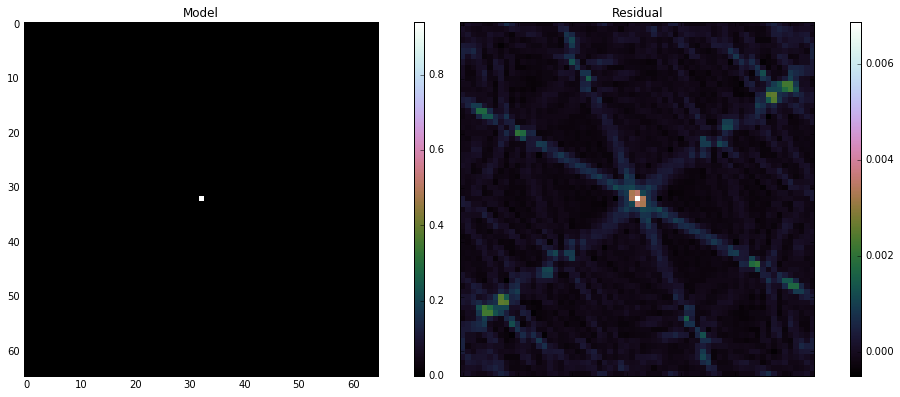

In [36]:
ch = nchan/2
F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(1, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("Model")
im = grid[0].imshow(IM[ch], interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("Residual")
im = grid[1].imshow(IR[ch], interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
plt.show()

In [37]:
I = np.argwhere(IM[ch] > 0.3)
Ix = I[:,0]
Iy = I[:,1]
for i in range(Ix.size):
    print r"Source at (%s, %s) has flux of %s Jy at v = %s Hz" % (Ix[i], Iy[i],IM[ch,Ix[i],Iy[i]],Freqs[ch])

Source at (32, 32) has flux of 0.940533420627 Jy at v = 1495000000.0 Hz


As long as there are two or more channels it is possible to fit a spectral index model to each source in the model image. This can be done by fitting a straight line to 
$$ \ln I = \ln I_0 + \alpha \ln (\frac{\nu}{\nu_0}), $$
or equivalently solving the linear system
$$ \left[ \begin{array}{c} \ln I(\nu_0) \\ \ln I(\nu_1) \\ \cdot \\ \ln I(\nu_{nv}) \end{array} \right] = \left[ \begin{array}{cc} 1 & \ln \frac{\nu_0}{\nu_{ref}} \\ 1 & \ln \frac{\nu_1}{\nu_{ref}} \\ \cdot & \cdot \\
1 & \ln \frac{\nu_{nv}}{\nu_{ref}} \end{array} \right] \left[ \begin{array}{c} \ln I(\nu_{ref}) \\ \alpha \end{array} \right] $$
where $nv$ is the number of channels/bands. We can do it for all the sources simultaneously by solving
$$ \left[ \begin{array}{cccc} \ln I_{s_1}(\nu_0) & \ln I_{s_2}(\nu_0) & \cdot & \cdot \\ \ln I_{s_1}(\nu_1) & \ln I_{s_2}(\nu_1) & \cdot & \cdot \\ \cdot \\ \ln I_{s_1}(\nu_{nv}) & \ln I_{s_2}(\nu_{nv}) & \cdot & \cdot \end{array} \right] = \left[ \begin{array}{cc} 1 & \ln \frac{\nu_0}{\nu_{ref}} \\ 1 & \ln \frac{\nu_1}{\nu_{ref}} \\ \cdot & \cdot \\
1 & \ln \frac{\nu_{nv}}{\nu_{ref}} \end{array} \right] \left[ \begin{array}{cccc} \ln I_{s_1}(\nu_{ref}) & \ln I_{s_2}(\nu_{ref}) & \cdot & \cdot \\ \alpha_{s_1} & \alpha_{s_2} & \cdot & \cdot \end{array} \right] $$
The code below fits a spectral model to the sources above some hand picked threshold.

In [38]:
def fit_SPI(IM,Freqs,ref_freq,threshold):
    nchan = Freqs.size
    #Find all sources with flux above threshold (should probably check this in each frequency band)
    I = np.argwhere(IM[nchan/2] > threshold)
    Ix = I[:,0]
    Iy = I[:,1]
    #Get the model Image as a function of frequency at all these locations
    nsource = Ix.size
    logIM = np.zeros([nchan,nsource])
    for i in xrange(nsource):
        logIM[:,i] = np.log(IM[:,Ix[i],Iy[i]])
        
    #Create the design matrix
    X = np.ones([nchan,2])
    X[:,1] = np.log(Freqs/ref_freq)
    
    #Solve the system
    logIref, alpha = np.dot(np.linalg.inv(X.T.dot(X)),np.dot(X.T,logIM))
    for i in xrange(nsource):
        print r"Source at (%s, %s) has flux of %s Jy at v = %s Hz and alpha = %s" % (Ix[i],Iy[i],np.exp(logIref[i]),ref_freq,alpha[i])    
    return np.exp(logIref), alpha

In [39]:
Iref, alpha = fit_SPI(IM,Freqs,ref_freq,0.4) #Note hard-coded threshold

Source at (32, 32) has flux of 0.940633777075 Jy at v = 1495000000.0 Hz and alpha = 1.00034990063


## Multi-Frequency-Synthesis

For MFS we start by expanding the model image $I^M(\nu)$ into a power series in frequency eg. 
$$ I^M(\nu) = \sum_{t=0}^{N_t-1} w(\nu)^t I^T_t, $$
where $I^T_t$ is the $t^{th}$ power series coefficient and $w(\nu)$ can be thought of as basis functions. Although this can be attempted for any power series the coeffcients only take on physical meaning when we have some a priori model for the frequency dependence of $I^M$. The most common such model is the spectral index model which postulates that 
$$ I^M(\nu) = I^M(\nu_0) \left(\frac{\nu}{\nu_0}\right)^\alpha, $$
where $\nu_0$ is some reference frequency. Performing a Taylor expansion about $\nu_0$ shows that if we use $w(\nu) = \left(\frac{\nu - \nu_0}{\nu_0}\right)$ as basis functions then the first few series coeficients can be related to $I^M_0 = I^M(\nu_0)$ and $\alpha$ according to  
$$ I^T_0 = I^M_0, \quad I^T_1 = \alpha I^M_0, $$
so that we get an alpha map from
$$ \alpha = \frac{I^T_1}{I^T_0}. $$
More complicated models can be used in a similar way. As we show below we can determine the coefficients $I^T$ corresponding to arbitrary weights $w(\nu)$. A model is only required to determine what these coefficients mean.

Substituting the series expansion into the expression for $V^{obs}$ gives
$$ V^{obs}_\nu = \sum_{t = 0}^{N_t-1} w(\nu)^t S_\nu F I^T_t = 
\left[ \begin{array}{cccc}
[ w^0_v S_v F] & [ w^1_v S_v F] & \cdot & \cdot
\end{array} \right] \left[\begin{array}{c} I^T_0 \\ I^T_1 \\ \cdot \\ \cdot \end{array} \right], $$
where in the last step we perform the summation using block matrices. MFS basically works by using all the visibility data (i.e. in each channel/band) to estimate the coefficients $I^T$. This can be achieved by solving the following system
$$
\left[ \begin{array}{cccc}
[ w^0_{v_1} S_{v_1} F] & [ w^1_{v_1} S_{v_1} F] & \cdot & \cdot \\
[ w^0_{v_2} S_{v_2} F] & [ w^1_{v_2} S_{v_2} F] & \cdot & \cdot \\
\cdot & \cdot & \cdot & \cdot
\end{array} \right] \left[\begin{array}{c} I^T_0 \\ I^T_1 \\ \cdot \\ \cdot \end{array} \right] = \left[\begin{array}{c} V^{obs}_{\nu_1} \\ V^{obs}_{\nu_2} \\ \cdot \\ \cdot \end{array} \right].
$$
The normal equations for this system can be found simply by multiplying through by the conjugate transpose of the matrix on the left
$$
\left[ \begin{array}{ccc}
[ w^0_{v_1} S^\dagger_{v_1} F^\dagger] & [w^0_{v_2} S^\dagger_{v_2} F^\dagger] & \cdot \\
[ w^1_{v_1} S^\dagger_{v_1} F^\dagger] & [ w^1_{v_2} S^\dagger_{v_2} F^\dagger] & \cdot \\
\cdot & \cdot & \cdot  \\
\cdot & \cdot & \cdot 
\end{array} \right]
\left[ \begin{array}{cccc}
[ w^0_{v_1} S_{v_1} F] & [ w^1_{v_1} S_{v_1} F] & \cdot & \cdot \\
[ w^0_{v_2} S_{v_2} F] & [ w^1_{v_2} S_{v_2} F] & \cdot & \cdot \\
\cdot & \cdot & \cdot & \cdot
\end{array} \right] \left[\begin{array}{c} I^T_0 \\ I^T_1 \\ \cdot \\ \cdot \end{array} \right] = 
\left[ \begin{array}{ccc}
[ w^0_{v_1} S^\dagger_{v_1} F^\dagger] & [w^0_{v_2} S^\dagger_{v_2} F^\dagger] & \cdot \\
[ w^1_{v_1} S^\dagger_{v_1} F^\dagger] & [ w^1_{v_2} S^\dagger_{v_2} F^\dagger] & \cdot \\
\cdot & \cdot & \cdot  \\
\cdot & \cdot & \cdot 
\end{array} \right]
\left[\begin{array}{c} V^{obs}_{\nu_1} \\ V^{obs}_{\nu_2} \\ \cdot \\ \cdot \end{array} \right].
$$
or
$$ H I^T = I^R, $$
where the images $I^R$ on the RHS are constructed from $I^D_{\nu}$ according to
$$ I^R_i = \sum_{\nu_k} w_{\nu_k}^i S^\dagger_{\nu_k} F^\dagger V^{obs}_{\nu_k} = \sum_{\nu_k} w_{\nu_k}^i I^D_{\nu_k}, $$
and the Hessian matrix consists of block matrices of the following form
$$ H_{ij} = \sum_{\nu_k} w_{\nu_k}^{i+j} F^\dagger S^\dagger_{\nu_k} S_{\nu_k} F. $$
Each Hessian block can be thought of as a spectral PSF (denoted $I^{PSF}_{i,j}$) and the solution to the normal equations returns the components $I^T$. The full Hessian matrix will not, in general, be invertible. However, by making the same assumptions as before, we can reduce each $H_{ij}$ to a single number viz. 
$$ \tilde{H}_{ij} = \sum_{\nu_k} w_{\nu_k}^{i + j} \mbox{mid}(I^{PSF}_{\nu_k}). $$
The deconvolution can be approximated by searching for the peak in $I^R_0$ (since $I^R_0 = \sum_{\nu_k} I^D_{\nu_k}$ this is similar to searching the average image over channels) and computing $I^T$ using
$$ I^T = H^{-1}I^R $$
The components of $I^T$ can be used to get $I^M$ so these components can be used to compute the predicted visibilities and hence update the residual image by evaluating the Jacobian in the major cycle. Subtraction within the image domain during the minor cycle is slightly trickier though. According to the original paper we have to update $I^R$ according to
$$ I^R_i = I^R_i - g \sum_{j = 0}^{N_t - 1} \hat{I}^{PSF}_{i,j} * I^T_{j,(k)}, $$
where $I^T_{j,(k)}$ is the j${}^{th}$ coefficient at iteration $k$ and $\hat{I}^{PSF}_{i,j}$ is the spectral PSF normalised by $\hat{I}^{PSF}_{0,0}$. Substituting in the definition $I^{PSF}_{ij} = \sum_{\nu_k} w_{\nu_k}^{i+j} F^\dagger S^\dagger_{\nu_k} S_{\nu_k} F$ shows that the minor cycle subtraction step is equivalent to
$$ I^R_{i,(k+1)} = I^R_{i,(k)} - g \sum_{\nu_k} w(\nu_k)^i \hat{I}^{PSF}_{\nu_k} \sum_{j = 0}^{N_t-1} w(\nu_k)^j I^T_{j,(k)} = I^R_i - g \sum_{\nu_k} w(\nu_k)^i \hat{I}^{PSF}_{\nu_k} I^M_{(k)}(\nu_k) $$
where we have used $I^M(\nu_k) = \sum_{j=0}^{N_t-1} w(\nu_k)^j I^T_j$. This should be compared with the definition of $I^R_i = \sum_{\nu_k} w_{\nu_k}^i I^D_{\nu_k}$. A crude implementation of this algorithm is given below. 

In [63]:
def CLEAN_MFS(Vobs,ID,PSF,Nt,Freqs,ref_freq,gridder,
             gamma = 0.05,threshold = "Default", nminoriter = 20,
             nmajoriter = 100):
    """
    This is a basic MFS CLEAN implemented using major and minor cycles. 
    Input:  Vobs = precalibrated visibilities
            lmn = the coordinates of the image
            K = the DFT kernel
            invK = the inverse DFT kernel
            PSF = the unnormalised PSF
    """
    #Initialise model image
    n = Vobs.shape[0]
    nchan = Vobs.shape[1]
    npix = ID.shape[2]
    IT = np.zeros([Nt,npix,npix])
    Istar = np.zeros(Nt)
    
    w = (Freqs - ref_freq)/ref_freq
    
    #Normalise PSF and ID keeping track of maximum
    PSF_max = np.zeros(nchan)
    for nu in xrange(nchan):
        PSF_max[nu] = np.max(PSF[nu])
        #PSF[i] /= PSF_max[0]
        #ID[i] /= PSF_max[0]

    #Compute weighted sum of dirty's
    print "Getting I from ID"
    IR = set_Dirty_Comps(ID,w,Nt)
    
    Itmp = IR[0] #this is where we do the peak finding
    
    #Find first maximum
    p,q = (argwhere(Itmp == Itmp.max())[0]).squeeze()
    Istarm = Itmp[p,q]
    
    #Set the Hessian and get inverse
    print "Setting H"
    invH, Ipsf = set_Hessian(PSF,PSF_max,w,Nt,nchan,npix)
    
    #Get principle solution (Taylor coefficients)
    Istar = np.dot(invH,IR[:,p,q])

    #Set threshold
    if threshold=="Default":
        threshold = 0.25*np.abs(Istarm) 
        print "Threshold set at ", threshold
    else:
        print "Assuming user set threshold"
        
    #Start deconvolution
    i = 0
    print "Deconvolving"
    while (i < nmajoriter) and (Istarm > 0.5*threshold):
        #Enter minor cycle
        j = 0
        while (j < nminoriter) and (Istarm > threshold):
            #print "j = ", j, "Istarm = ", Istarm, "Istar = ", Istar
            #Update model image
            IT[:,p,q] += gamma*Istar
            
            #Do image plane subtraction
            for t in xrange(Nt):
                tmp = 0.0
                for k in range(Nt):
                    tmp += gamma*Istar[k]*Ipsf[t,k,npix - p:2*npix - p,npix - q:2*npix - q]
                IR[t] -= tmp
            
            #Get new I to search in
            #I = set_Dirty_Comps(IR,w,Nt)
            Itmp = IR[0]
            
            #Get new indices where I is max
            p,q = (argwhere(Itmp == Itmp.max())[0]).squeeze()
            Istarm = Itmp[p,q]
            
            #Solve of IT
            Istar = np.dot(invH,IR[:,p,q])
            
            #Increment minor cycle counter
            j += 1         
        #Increment major cycle counter
        i += 1
            
        #Update IT
        IT[:,p,q] += gamma*Istar
        
        #Get residual image
        IR = get_Jacobian_MFS(Vobs,IT,npix,PSF_max,gridder,w,Nt)
        
        #Find next peak
        Itmp = IR[0]
        p,q = (argwhere(Itmp == Itmp.max())[0]).squeeze()
        Istarm = Itmp[p,q]
        
        #get principal solution
        Istar = np.dot(invH,IR[:,p,q])
        
        if i%5==0:
            print "i = ", i, "j = ", j, "Istarm = ", Istarm
    
            
    #Warn if number of iterations exceeded
    if i >= nmajoriter:
        print "Max iterations exceeded. Istarm = ",Istarm
    
    print "Done"
    
    #Get IM
    IM = np.zeros([nchan,npix,npix])
    for nu in xrange(nchan):
        for t in xrange(Nt):
            IM[nu] += w[nu]**t*IT[t] 
    
    #Get alpha map (we only compute this for pixels above a certain threshold)
    
    I = np.argwhere(IM[nchan/2] > threshold) #.squeeze()
    Ix = I[:,0]
    Iy = I[:,1]
    alpha = np.zeros([npix,npix])
    alpha[Ix,Iy] = IT[1,Ix,Iy]/IT[0,Ix,Iy]
    return IM, IT, IR , alpha

def get_Jacobian_MFS(Vobs,IT,npix,PSF_max,gridder,w,Nt):
    #Get number of channels/bands
    n = Vobs.shape[0]
    nchan = Vobs.shape[1]
    npix = IT.shape[-1]

    IM = np.zeros([nchan,npix,npix])
    for k in xrange(nchan):
        for l in xrange(Nt):
            IM[k] += w[k]**l*IT[l]            
    
    Vpred = gridder.do_DFT_Vpred(IM)
    
    #Get residual vis
    Vres = Vobs - Vpred
    
    #Get residual image
    ID = np.real(gridder.give_IR(Vres))
    
    #Get I
    IR = set_Dirty_Comps(ID,w,Nt)
    return IR

def set_Hessian(PSF,PSF_max,w,Nt,nchan,npix):
    """
    Constructs principal components of the Hessian
    """
    #Create array to store Hessian
    H = np.zeros([Nt,Nt])
    Ipsf = np.zeros([Nt,Nt,2*npix,2*npix])
    #Compute Hessian
    for i in xrange(Nt):
        for j in xrange(Nt):
            for k in range(nchan): 
                H[i,j] += w[k]**(i+j)*PSF_max[k]
                Ipsf[i,j] += w[k]**(i+j)*PSF[k]
    return np.linalg.inv(H), Ipsf/Ipsf[0,0].max()

def set_Dirty_Comps(ID,w,Nt):
    nchan,nx,ny = ID.shape
    IR = np.zeros([Nt,nx,ny])
    for t in xrange(Nt):
        for i in xrange(nchan):
            IR[t] += w[i]**t*ID[i]
    return IR

In [64]:
Nt = 3
IM, IT, IR, alpha = CLEAN_MFS(Vobs.copy(),ID.copy(),PSF.copy(),Nt,Freqs,ref_freq,gridder)

Getting I from ID
Setting H
Threshold set at  0.453378576362
Deconvolving
i =  5 j =  0 Istarm =  0.282015757129
i =  10 j =  0 Istarm =  0.218208396314
Done


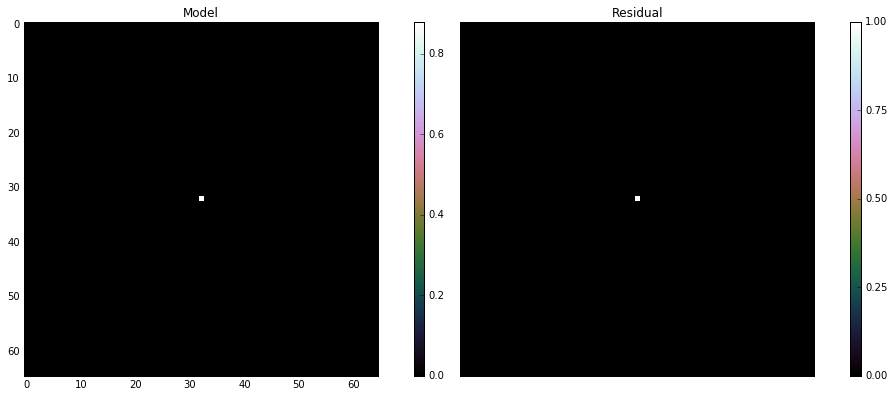

In [65]:
ch = 0
F = plt.figure(1,(15,15))
grid = ImageGrid(F, 111,  # similar to subplot(111)
                nrows_ncols=(1, 2),
                direction="row",
                axes_pad=0.5,
                add_all=True,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%")

grid[0].set_title("Model")
im = grid[0].imshow(IM[ch], interpolation="nearest", cmap="cubehelix")
grid[0].cax.colorbar(im)
grid[1].set_title("Residual")
im = grid[1].imshow(IR[ch], interpolation="nearest", cmap="cubehelix")
grid[1].cax.colorbar(im)
plt.show()

In [67]:
#I = np.argwhere(IM[ch] > 0.25)
I = np.argwhere(abs(alpha) > 0.1)
Ix = I[:,0]
Iy = I[:,1]
for i in range(Ix.size):
    #print r"Source at (%s, %s) has flux of %s Jy at v = %s Hz" % (Ix[i], Iy[i],IM[ch,Ix[i],Iy[i]],Freqs[ch])
    print r"Source at (%s, %s) has alpha = %s Jy" % (Ix[i], Iy[i],alpha[Ix[i],Iy[i]])

Source at (32, 32) has alpha = 1.00038108184 Jy
